<a href="https://colab.research.google.com/github/VectorInstitute/ProjectLongCovid-NER/blob/main/Twitter_SyCo_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Authenticate User
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [16]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt # Visualization library
import seaborn as sns # Visualization library
from ast import literal_eval #string list to Python list

In [2]:
# import the lancet dictionary & categories for semantic search
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer('all-MiniLM-L6-v2')
url = 'https://docs.google.com/spreadsheets/d/1Y1Y4_uauW3c4Pxhjarz3puKkts2BXQh9K87qkUuaExA/edit?usp=sharing'
wb_db = gc.open_by_url(url)
sheet = wb_db.worksheet('lancet') #Pull the section
df_lancet = pd.DataFrame(sheet.get_all_values()) #transform values into a dataframe
df_lancet.columns = ['symptoms','categories','abr_symptoms']
df_lancet = df_lancet[1:]
corpus = df_lancet.symptoms.tolist()
corpus_abr = df_lancet.abr_symptoms.tolist()
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
#df_twitter.to_csv('df_twitter.csv')
url = 'https://docs.google.com/spreadsheets/d/1p_Ut-GlQghC8v_rhXURGp5lY8l-oXwHhVSBpr8m2S-w/edit?usp=sharing'
wb_db = gc.open_by_url(url)
sheet = wb_db.worksheet('twitter') #Pull the section
df_rl = pd.DataFrame(sheet.get_all_values()) #transform values into a dataframe
df_rl.columns =  df_rl.iloc[0] 
df_twitter = df_rl.drop(df_rl.index[0]) #Drop first row


In [60]:
# groupby based on symptoms
df_grouped = df_twitter.copy()
df_grouped = df_grouped.groupby(by='symptom_adjusted').size().to_frame('frequency').reset_index().sort_values('frequency', ascending=False)
tot_occurence_sosy = df_grouped.frequency.sum()
N0_extracted_sosy = len(df_grouped['symptom_adjusted'])

# semantic search based on Lancet
N = N0_extracted_sosy#1000 # #Assign benchmark - sum of top N symptom frequencies for semantic search
queries = df_grouped.head(N)['symptom_adjusted'].to_list()
#queries = df_grouped['symptom_adjusted'].to_list()
df_grouped['semantics']=None
df_grouped['score']=None
top_k = min(3, len(corpus))
#list_matched=[]
#list_removed=[]
#for query in queries:
    #query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    #cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    #top_results = torch.topk(cos_scores, k=top_k)
    #list_matched.append(corpus_abr[top_results[1][0]])
    #list_removed.append(top_results[0][0].numpy())

#df_grouped.head(N)['semantics']=list_matched
#df_grouped.head(N)['score']=list_removed

df_grouped['semantics']=list_matched
df_grouped['score']=list_removed

# replace symptoms with semantics
cut_off_thresh = 0.45
df_temp_cutoff = df_grouped[df_grouped['score']>cut_off_thresh]
df_temp_cutoff = df_temp_cutoff[df_temp_cutoff['semantics']!='']
df_grouped_semantic_mapped = df_temp_cutoff.groupby(by='semantics')['frequency'].sum().to_frame('count').reset_index().sort_values('count', ascending=False)

# add semantics to the original tweet dataset df_raw_nonan
temp = pd.merge(left=df_twitter, right=df_temp_cutoff, how="left", left_on='symptom_adjusted', right_on='symptom_adjusted')
df_twitter = temp.drop(['frequency'], axis=1)

df_grouped_semantic_mapped.columns = ['symptom_adjusted','frequency']
df_grouped_mapped_category=pd.merge(left=df_grouped_semantic_mapped, right=df_lancet, how="left", left_on='symptom_adjusted', right_on='abr_symptoms')
df_grouped_mapped_category=df_grouped_mapped_category[['symptom_adjusted', 'frequency','categories']]
df_grouped_mapped_category.columns=['symptom','frequency','lancet_category']

# merge to add lancet categories to the original tweet dataset
temp = pd.merge(left=df_twitter, right=df_grouped_mapped_category, how="left", left_on='semantics', right_on='symptom')
temp.drop(['symptom'], axis=1)
df_twitter = temp.drop(['frequency','semantics'], axis=1)


# Occurence Frequency Counts

In [62]:
df_grouped_new = df_twitter.copy()
df_grouped_new = df_grouped_new.groupby(by='symptom').size().to_frame('frequency').reset_index().sort_values('frequency', ascending=False)
df_grouped_mapped_category=pd.merge(left=df_grouped_new, right=df_lancet, how="left", left_on='symptom', right_on='abr_symptoms')
df_grouped_mapped_category = df_grouped_mapped_category[['symptom','frequency','categories']]
df_grouped_mapped_category.columns=['symptom','frequency','lancet_category']
df_grouped_mapped_category = df_grouped_mapped_category[~df_grouped_mapped_category['lancet_category'].isin(['Noise'])]
bm_sosy_c_all = df_grouped_mapped_category['frequency'].sum()
df_grouped_mapped_category['perc'] = 100*df_grouped_mapped_category['frequency']/bm_sosy_c_all 
df_grouped_mapped_category.head(10)

,symptom,frequency,lancet_category,perc
0,Fatigue,3420,Systemic,7.828237
2,Numbness,2847,Neuropsychiatric (Sensorimotor),6.516664
3,Numbness,2847,Neuropsychiatric (Sensorimotor),6.516664
4,Numbness,2847,HEENT,6.516664
5,Tachycardia,2656,Cardiovascular,6.079473
6,Tachycardia,2656,Cardiovascular,6.079473
7,Infection,1800,uncategorized,4.120125
8,Anxiety,1144,Neuropsychiatric (Emotion&Mood),2.618568
9,Pain (general),1120,uncategorized,2.563633
10,Shortness of Breath,1080,Pulmonary,2.472075


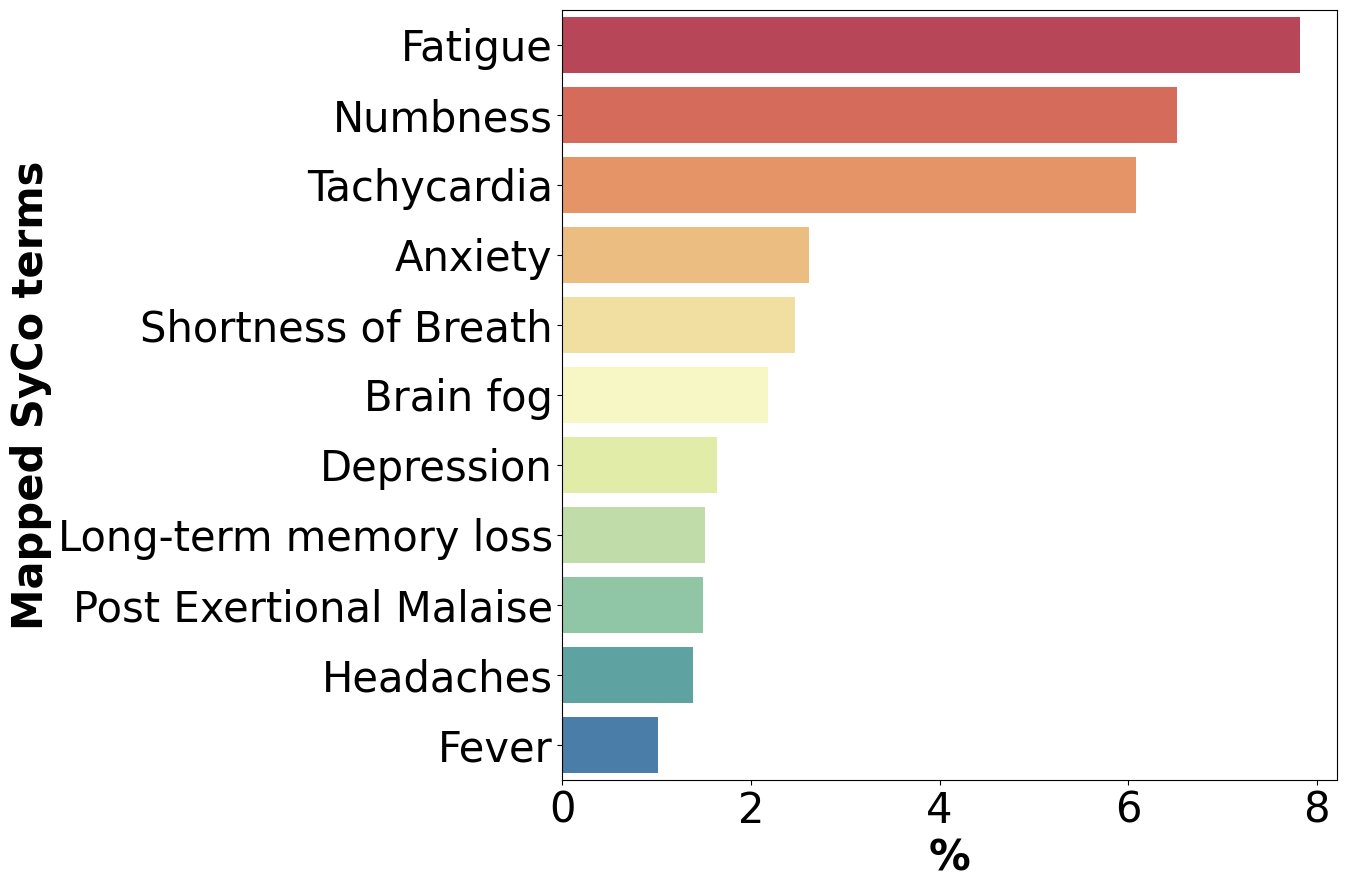

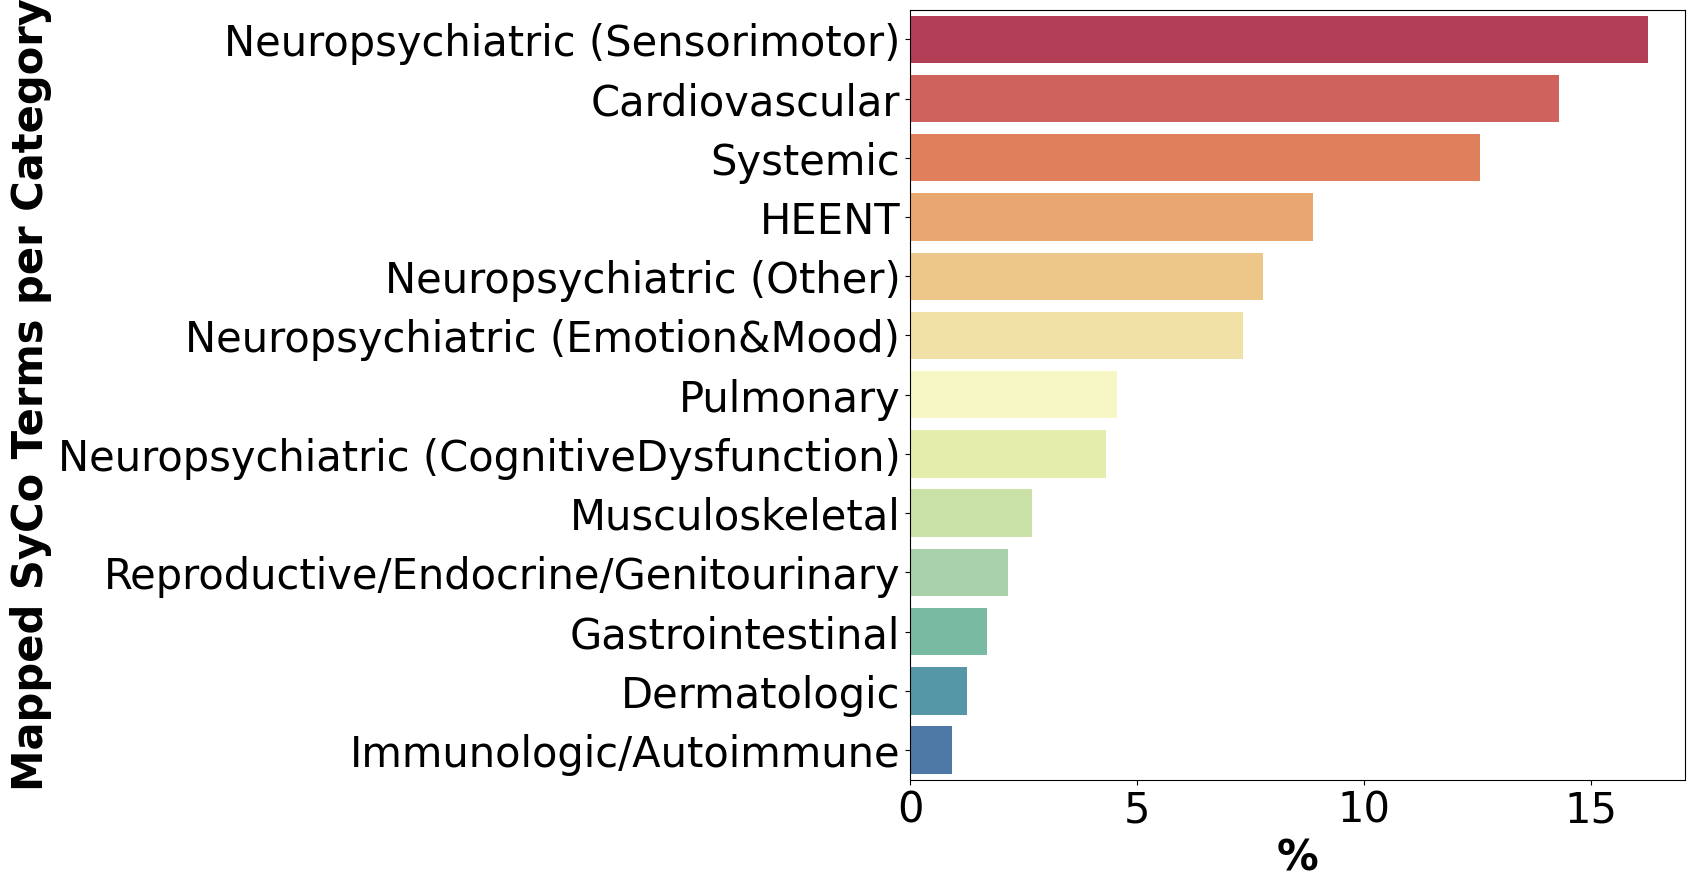

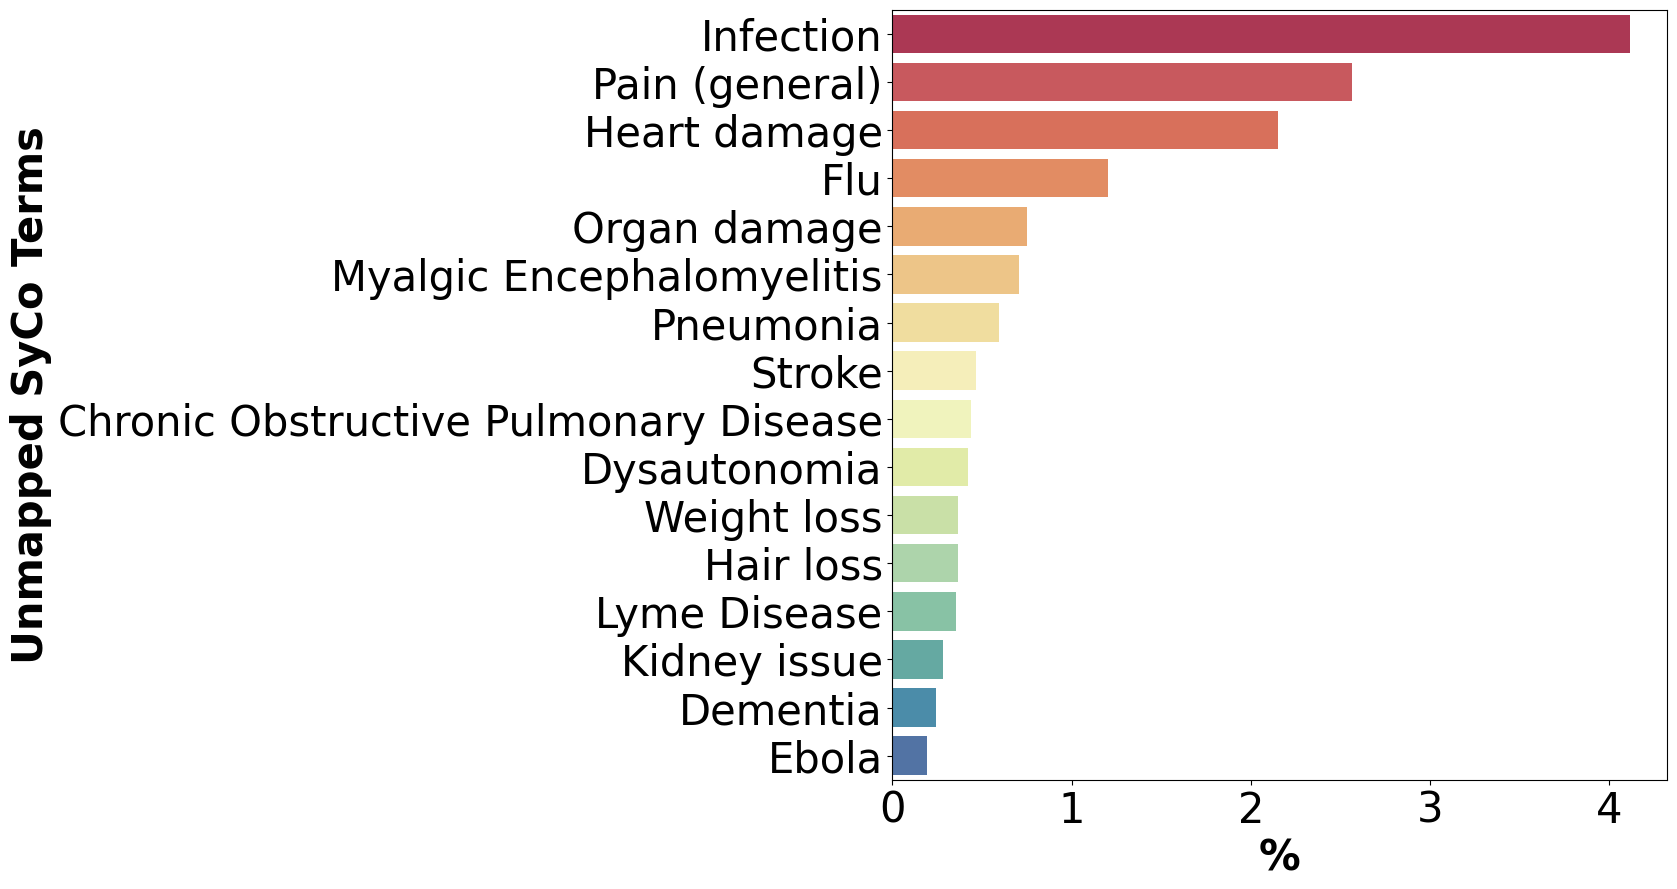

In [63]:
# Plotting
# SyCo occurence
df_plot = df_grouped_mapped_category[~df_grouped_mapped_category.lancet_category.isin(['uncategorized','noise'])]
ax = plt.subplots(figsize=(10, 10))
ax= sns.barplot(x="perc", y="symptom", data = df_plot[df_plot['perc']>1], palette = 'Spectral')
#Additional parameters
y_label=ax.set_ylabel('Mapped SyCo terms',fontsize=30,fontweight='bold')
x_label=ax.set_xlabel('%',fontsize=30,fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=30)

# categories occurence
df_plot = df_plot.groupby(by='lancet_category')['frequency'].sum().to_frame('count').reset_index().sort_values('count', ascending=False)
df_plot['perc'] = 100*df_plot['count']/bm_sosy_c_all
ax = plt.subplots(figsize=(10, 10))
ax= sns.barplot(x="perc", y="lancet_category", data = df_plot, palette = 'Spectral')
#Additional parameters
y_label=ax.set_ylabel('Mapped SyCo Terms per Category',fontsize=30,fontweight='bold')
x_label=ax.set_xlabel('%',fontsize=30,fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=30)

# categories occurence
df_plot = df_grouped_mapped_category[df_grouped_mapped_category.lancet_category.isin(['uncategorized'])].head(16)
df_plot[~df_plot['symptom'].isin(['unwell','cancer'])]
ax = plt.subplots(figsize=(10, 10))
ax= sns.barplot(x="perc", y="symptom", data = df_plot, palette = 'Spectral')
#Additional parameters
y_label=ax.set_ylabel('Unmapped SyCo Terms',fontsize=30,fontweight='bold')
x_label=ax.set_xlabel('%',fontsize=30,fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=30)



**SpatioTemporal Analysis**

In [64]:
all_groups_names = df_grouped_mapped_category['lancet_category'].unique()
df_final_sosy_c = df_twitter[df_twitter['lancet_category'].isin(all_groups_names)]
temp = df_final_sosy_c.groupby('country').size().to_frame('count').reset_index().sort_values('count', ascending=False)
temp['perc'] = temp['count']/bm_sosy_c_all
# spatial analysis
print ('include country',temp['count'].sum()/bm_sosy_c_all)
temp.to_csv('country_perc.csv')
all_country_names = temp.country.to_list()

df_country = pd.DataFrame(index =all_groups_names, columns = all_country_names)
for term_ in all_groups_names:
  bm = df_grouped_mapped_category[df_grouped_mapped_category['lancet_category']==term_]['frequency'].sum()
  temp = df_final_sosy_c[df_final_sosy_c['lancet_category']==term_].groupby('country').size().to_frame('count').reset_index()
  temp['perc'] = 100*temp['count']/bm
  temp.index = temp['country']
  temp.drop('country',axis=1)
  df_country.loc[term_] = temp['perc']
df_country[df_country<1] = np.nan
df_country = df_country.dropna(axis=1, how='all')

include country 0.802508698040652


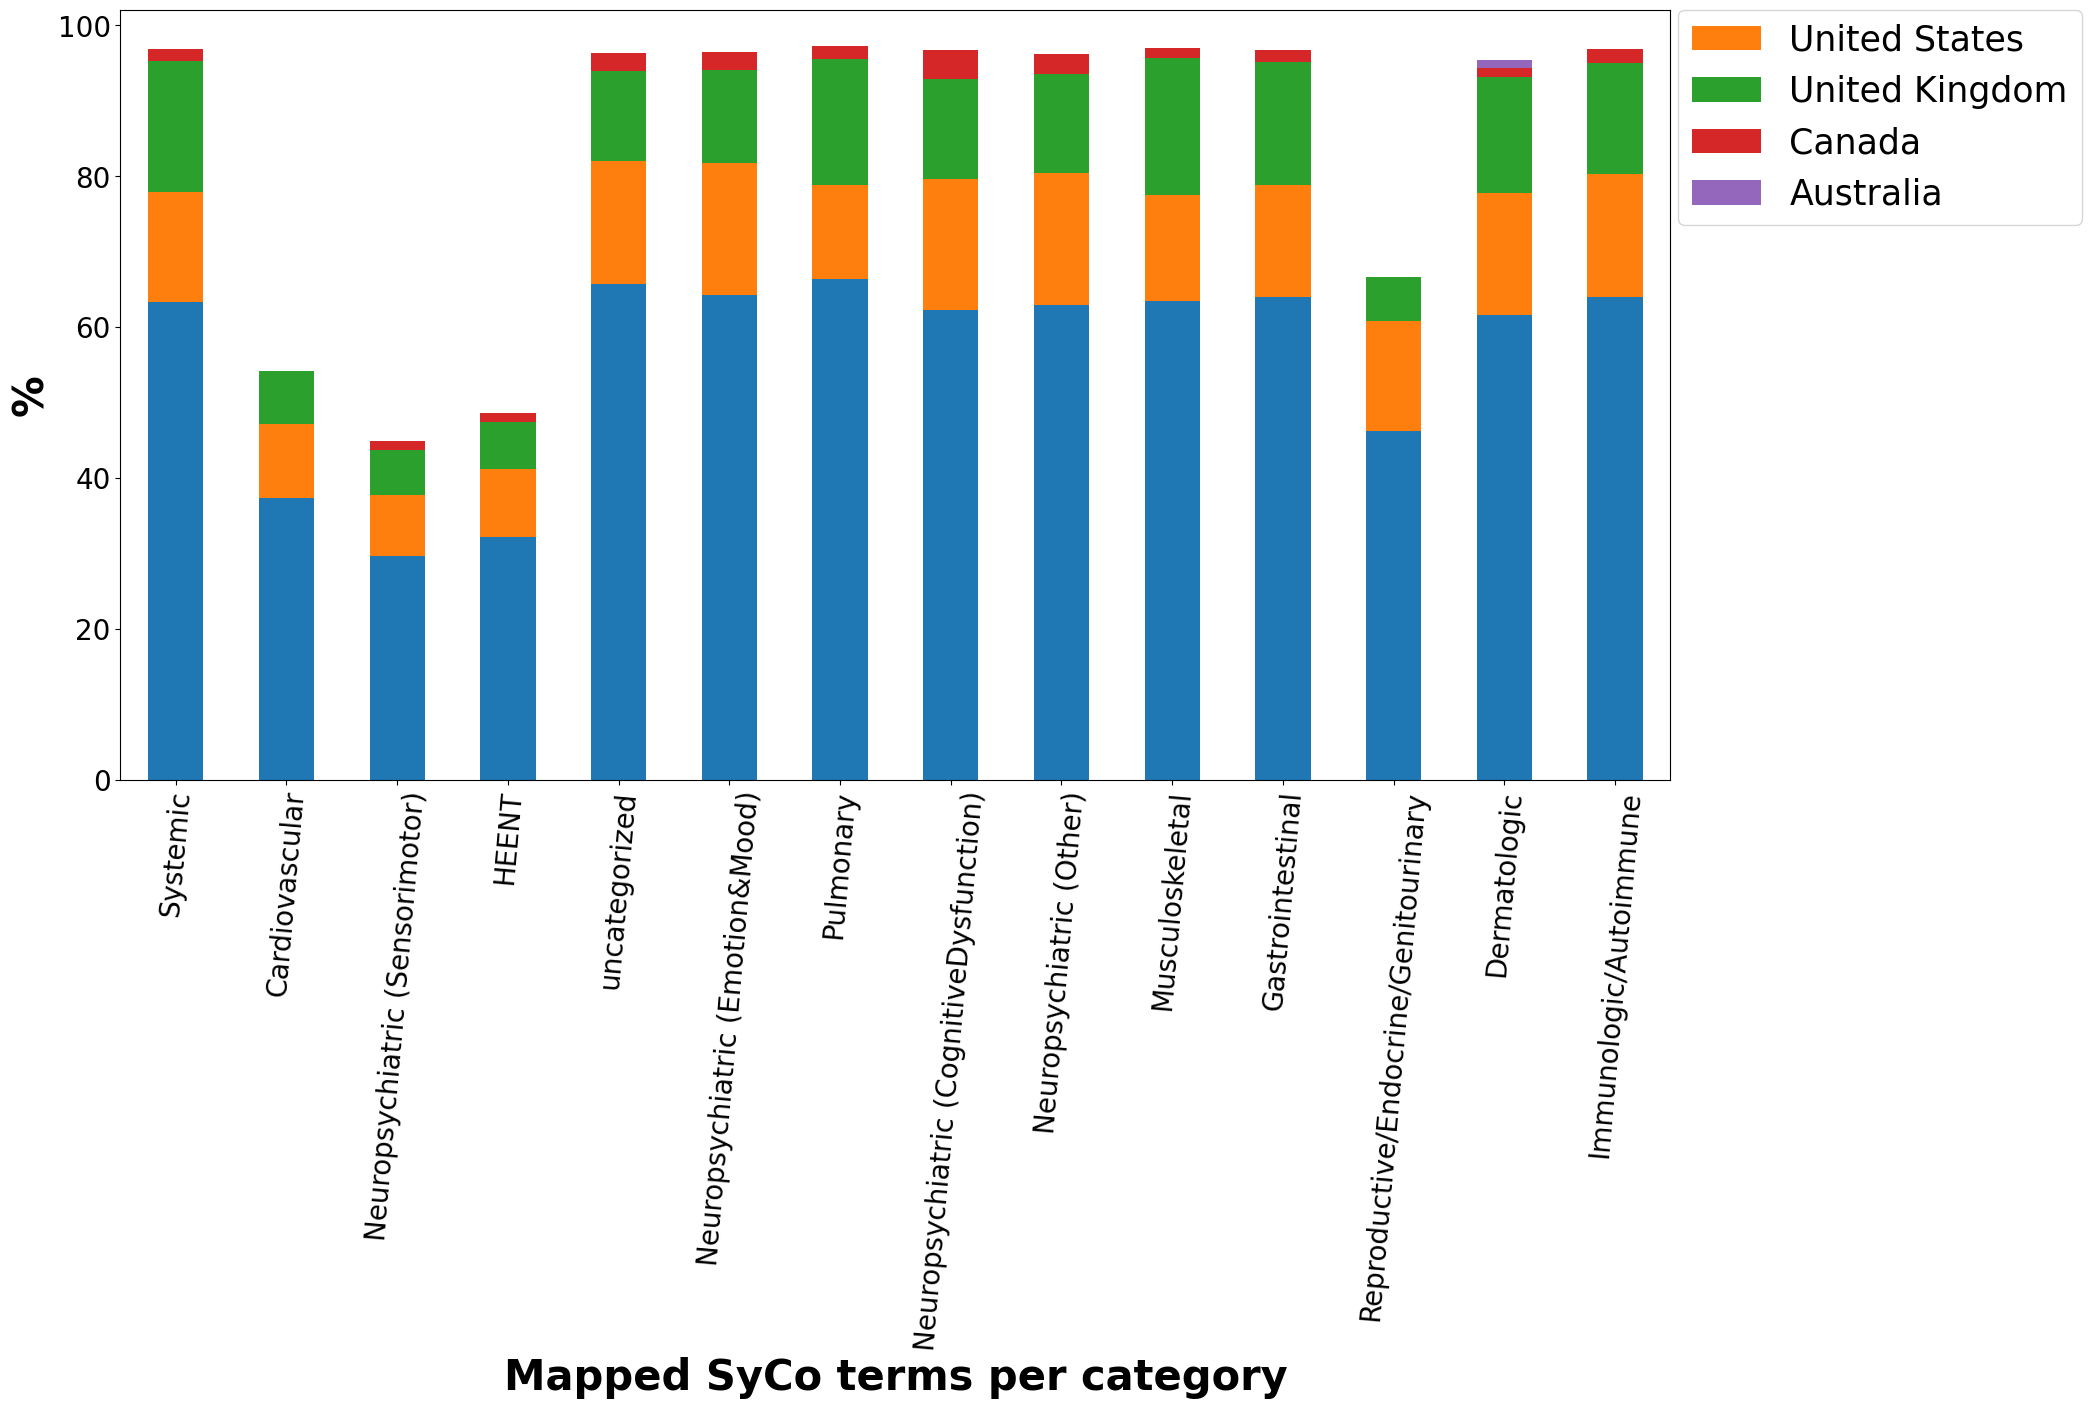

In [54]:
# plotting
#set seaborn plotting aesthetics
ax = df_country.plot.bar(stacked=True,figsize=(20,10),rot = 85)
#add overall title

plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0, prop={'size': 25})

#add axis titles
y_label=ax.set_ylabel('%',fontsize=30,fontweight='bold')
x_label=ax.set_xlabel('Mapped SyCo terms per category',fontsize=30,fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=20)

In [65]:
df_twitter.to_csv('tweets_SyCo_geo.csv')